In [2]:
ev['cam'].keys()

dict_keys(['loaded', 'c1', 'c2', 'c3'])

In [4]:
ev['cam']['c2'].keys()

dict_keys(['index', 'timestamp', 'pts', 'timediff', 'skipped', 'pixdiff', 'frame1', 'frame14', 'frame6', 'frame18', 'frame17', 'frame12', 'frame8', 'frame3', 'frame13', 'frame5', 'frame10', 'frame16', 'frame11', 'frame19', 'frame2', 'frame15', 'frame4', 'frame9', 'frame7', 'frame0'])

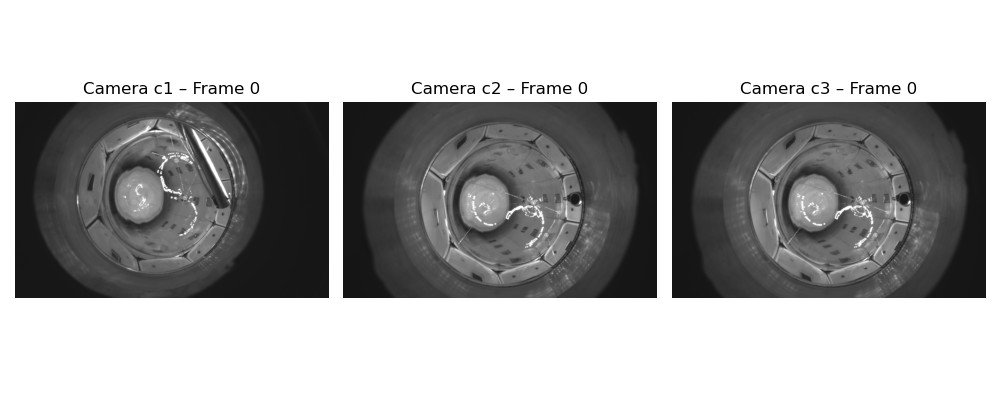

In [9]:
# Load frames
img1 = ev['cam']['c1']['frame0']
img2 = ev['cam']['c2']['frame0']
img3 = ev['cam']['c3']['frame0']

# Create 1 row × 3 column subplot
fig, axes = plt.subplots(1, 3, figsize=(10, 4))  # wider figure for side-by-side

# Plot each image
axes[0].imshow(img1)
axes[0].set_title("Camera c1 – Frame 0")
axes[0].axis("off")

axes[1].imshow(img2)
axes[1].set_title("Camera c2 – Frame 0")
axes[1].axis("off")

axes[2].imshow(img3)
axes[2].set_title("Camera c3 – Frame 0")
axes[2].axis("off")

plt.tight_layout()
plt.show()

In [2]:
from sbcbinaryformat import Streamer, Writer
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import copy
import ipympl
import matplotlib.animation as animation
import re
from matplotlib.gridspec import GridSpec



from GetEvent import GetEvent

ll = ['cam','run_control']

TEST_RUN = "/exp/e961/data/SBC-25-daqdata/20250821_14/"
#TEST_RUN = "/exp/e961/data/SBC-25-daqdata/20250718_4/"

TEST_EVT = 2

#data = GetEvent(TEST_RUN, TEST_EVT,*ll)
ev = GetEvent(TEST_RUN, TEST_EVT, strictMode=False, *ll)


#Helper function to list the frames in the right order
def pull_sequence(cam_dict):
    """Return list of frames in order"""
    seq = []
    i = 0
    while f"frame{i}" in cam_dict:
        seq.append(cam_dict[f"frame{i}"])
        i += 1
    return seq


# pick cameras that actually have a sequential set and find number of frames
cam_order = []
frames = {}
cams_all = ev.get('cam', {})
for c, d in cams_all.items():
    if isinstance(d, dict):
        seq = pull_sequence(d)
        if len(seq) > 0:
            cam_order.append(c)
            frames[c] = seq
n_frames = len(next(iter(frames.values())))

Synchronized across cams ['c1', 'c2']. Using 20 frames.


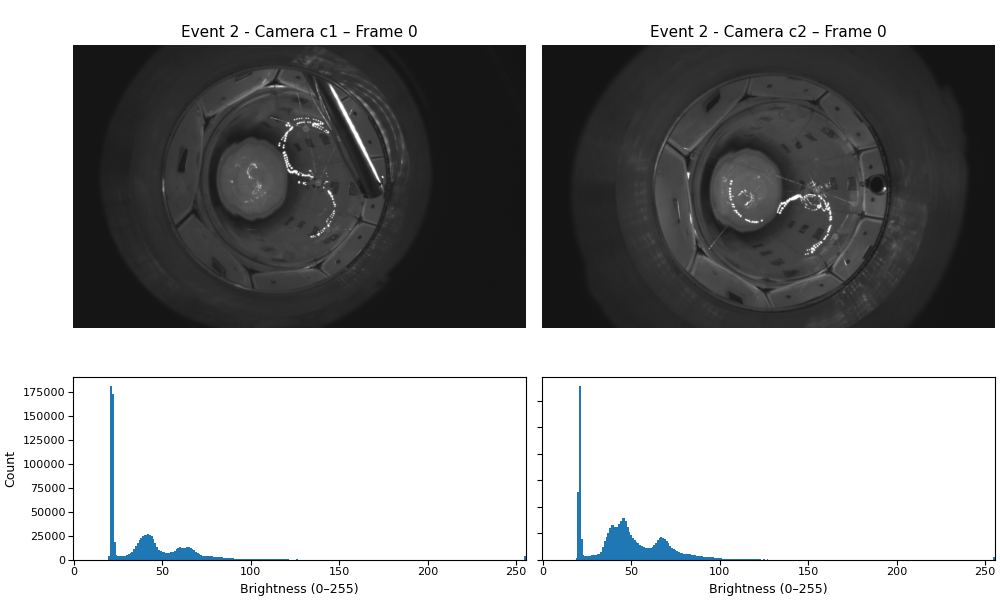

In [3]:
print(f"Synchronized across cams {cam_order}. Using {n_frames} frames.")
if len(cam_order) == 0:
    raise ValueError("No cameras with sequential frames found (frameN).")


# ---------- figure setup ----------
fig = plt.figure(figsize=(10, 6), constrained_layout=True)
gs  = GridSpec(2, len(cam_order), figure=fig, height_ratios=[2, 1])

titles = {c: f"Event {TEST_EVT} - Camera {c}" for c in cam_order}
ax_img, ims, bars = [], {}, {}

for j, c in enumerate(cam_order):
    # ---- image ----
    ax = fig.add_subplot(gs[0, j]); ax_img.append(ax)
    im0 = frames[c][0]
    ims[c] = ax.imshow(im0, cmap="gray")
    ax.axis("off")
    ax.set_title(f"{titles[c]} – Frame 0", fontsize=11)

    # ---- histogram (initial, updatable) ----
    axh = fig.add_subplot(gs[1, j])
    base0 = im0[..., 0]
    bars[c] = axh.bar(
        range(256),
        np.histogram(base0.ravel(), bins=256, range=(0, 256))[0],
        width=1.0, align='center', edgecolor='none'
    )
    axh.set_xlim(-0.5, 255.5)
    axh.set_xlabel("Brightness (0–255)", fontsize=9)
    (axh.set_ylabel("Count", fontsize=9) if j == 0 else axh.set_yticklabels([]))
    axh.tick_params(axis='both', labelsize=8, pad=2)
    axh.margins(x=0)

# ---------- animation update ----------
def update(i):
    if i < n_frames:
        for j, c in enumerate(cam_order):
            im = frames[c][i]
            ims[c].set_array(im)
            ax_img[j].set_title(f"{titles[c]} – Frame {i}", fontsize=11)

            base = im[..., 0] if im.ndim == 3 else im
            h = np.histogram(base.ravel(), bins=256, range=(0, 256))[0]
            for b, height in zip(bars[c], h):
                b.set_height(int(height))
    else:
        # show white when finished
        white = np.full_like(np.asarray(frames[cam_order[0]][0]), 255)
        for j, c in enumerate(cam_order):
            ims[c].set_array(white)
            ax_img[j].set_title(f"{titles[c]} – END", fontsize=11)
            for b in bars[c]:
                b.set_height(0)

    artists = list(ims.values())
    for c in cam_order:
        artists.extend(bars[c])
    return artists

# ---------- run animation ----------
anim = animation.FuncAnimation(
    fig, update,
    frames=list(range(n_frames)) + [n_frames],
    interval=500, blit=False
)

plt.show()

In [4]:
anim.event_source.stop()

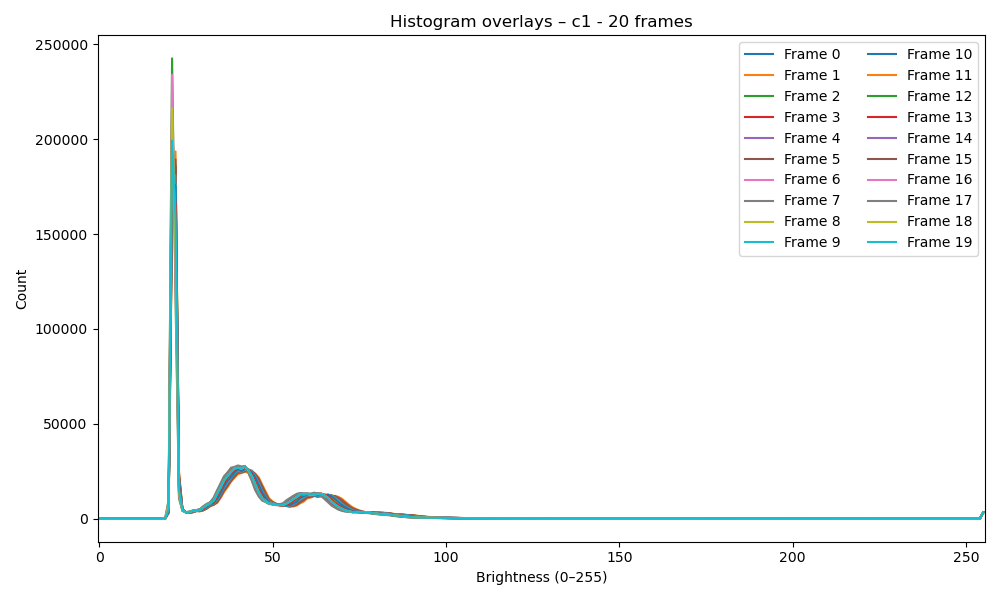

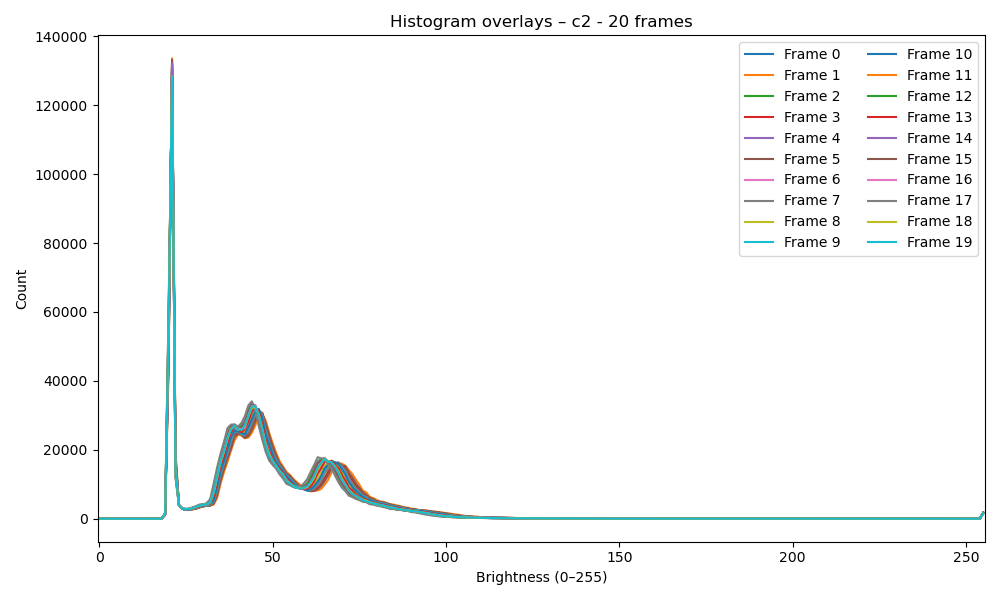

In [5]:
for cam in cam_order:
    # histogram bins
    edges   = np.arange(-0.5, 256.5, 1.0)
    centers = np.arange(256)
    
    plt.figure(figsize=(10,6))
    for idx in range(n_frames):
        im = frames[cam][idx]
        base = im[...,0]
        h, _ = np.histogram(base.ravel(), bins=edges)
        plt.plot(centers, h, label=f"Frame {idx}")
    
    plt.xlim(-0.5, 255.5)
    plt.xlabel("Brightness (0–255)")
    plt.ylabel("Count")
    plt.title(f"Histogram overlays – {cam} - {n_frames} frames")
    
    # force legend to top-right with 2 columns
    plt.legend(loc="upper right", ncol=2)
    
    plt.tight_layout()
    plt.show()

Synchronized across cams ['c1', 'c2']. Using 20 frames.


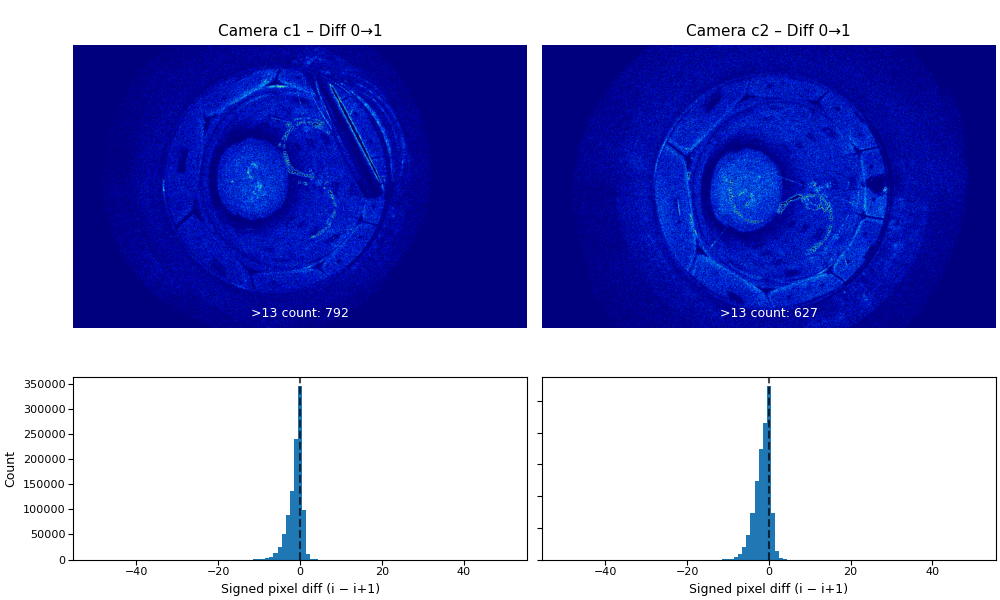

In [6]:
print(f"Synchronized across cams {cam_order}. Using {n_frames} frames.")

# ---- figure: 2 rows × (#cams) ----
fig = plt.figure(figsize=(10, 6), constrained_layout=True)
gs  = GridSpec(2, len(cam_order), figure=fig, height_ratios=[2, 1])

titles = {c: f"Camera {c}" for c in cam_order}
ax_img, ims, bars, count_texts = [], {}, {}, {}

def make_diff_pair(im_a, im_b):
    """Return (display_diff_abs_thresholded, signed_diff_array)."""
    a = np.float64(im_a)
    b = np.float64(im_b)
    signed = a - b                       # signed difference
    absd   = np.abs(signed)
    absd[absd <= 2] = 0.0                # threshold for display
    disp = absd.mean(axis=-1) if absd.ndim == 3 else absd
    return disp, signed

# ---- init with diff 0→1 ----
for j, c in enumerate(cam_order):
    # top: diff image
    ax = fig.add_subplot(gs[0, j]); ax_img.append(ax)
    disp0, signed0 = make_diff_pair(frames[c][0], frames[c][1])
    ims[c] = ax.imshow(disp0, cmap='jet')
    ax.axis("off")
    ax.set_title(f"{titles[c]} – Diff 0→1", fontsize=11)
    # optional count text (abs diff > 13)
    ct = ax.text(0.5, 0.03, f">13 count: {(np.abs(signed0) > 13).sum():,}",
                 color='white', fontsize=9, ha='center', va='bottom',
                 transform=ax.transAxes)
    count_texts[c] = ct

    # bottom: histogram of signed difference
    axh = fig.add_subplot(gs[1, j])
    base0 = signed0[..., 0] if signed0.ndim == 3 else signed0
    counts = np.histogram(base0.ravel(), bins=111, range=(-55.5, 55.5))[0]  # bins center at −55..55
    xcenters = np.arange(-55, 56)                                           # −55..55 (111 values)
    bars[c] = axh.bar(xcenters, counts, width=1.0, align='center', edgecolor='none')
    axh.set_xlim(-55.5, 55.5)
    axh.axvline(0, color='k', linestyle='--', alpha=0.7)
    axh.set_xlabel("Signed pixel diff (i − i+1)", fontsize=9)
    (axh.set_ylabel("Count", fontsize=9) if j == 0 else axh.set_yticklabels([]))
    axh.tick_params(axis='both', labelsize=8, pad=2)
    axh.margins(x=0)

# ---- animate diffs i→i+1 ----
n_diff = max(n_frames - 1, 1)

def update(i):
    for j, c in enumerate(cam_order):
        disp, signed = make_diff_pair(frames[c][i], frames[c][i+1])
        ims[c].set_array(disp)
        ax_img[j].set_title(f"{titles[c]} – Diff {i}→{i+1}", fontsize=11)
        count_texts[c].set_text(f">13 count: {(np.abs(signed) > 13).sum():,}")

        base = signed[..., 0] if signed.ndim == 3 else signed
        h = np.histogram(base.ravel(), bins=111, range=(-55.5, 55.5))[0]
        for b, height in zip(bars[c], h):
            b.set_height(int(height))

    artists = list(ims.values()) + list(count_texts.values())
    for c in cam_order:
        artists.extend(bars[c])
    return artists

anim_diff = animation.FuncAnimation(
    fig, update,
    frames=list(range(n_diff)),
    interval=500, blit=False
)

plt.show()

In [7]:
anim_diff.event_source.stop()

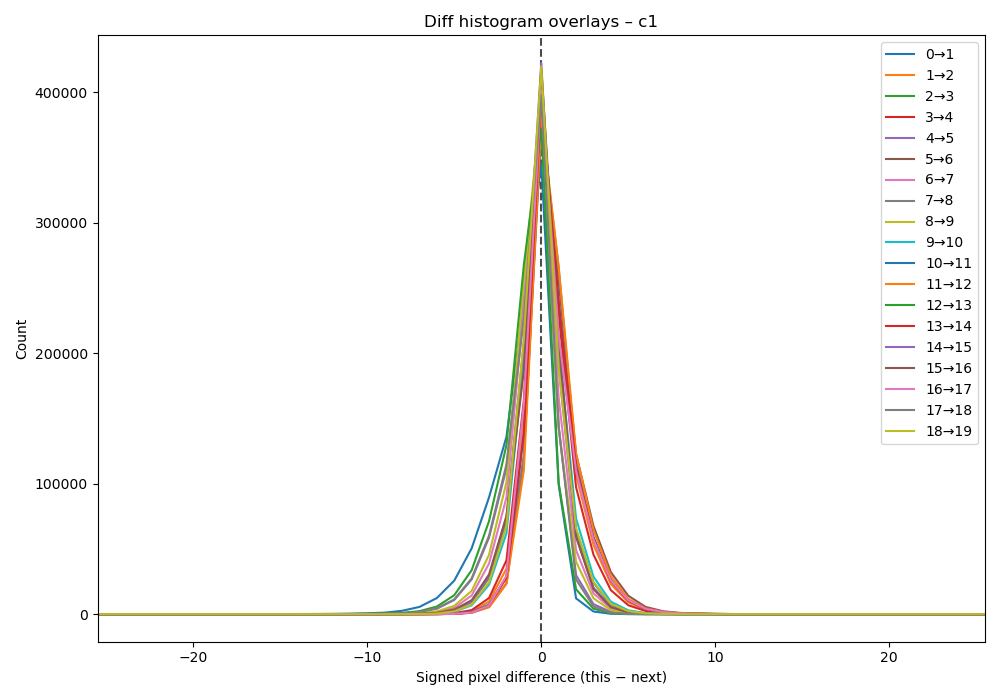

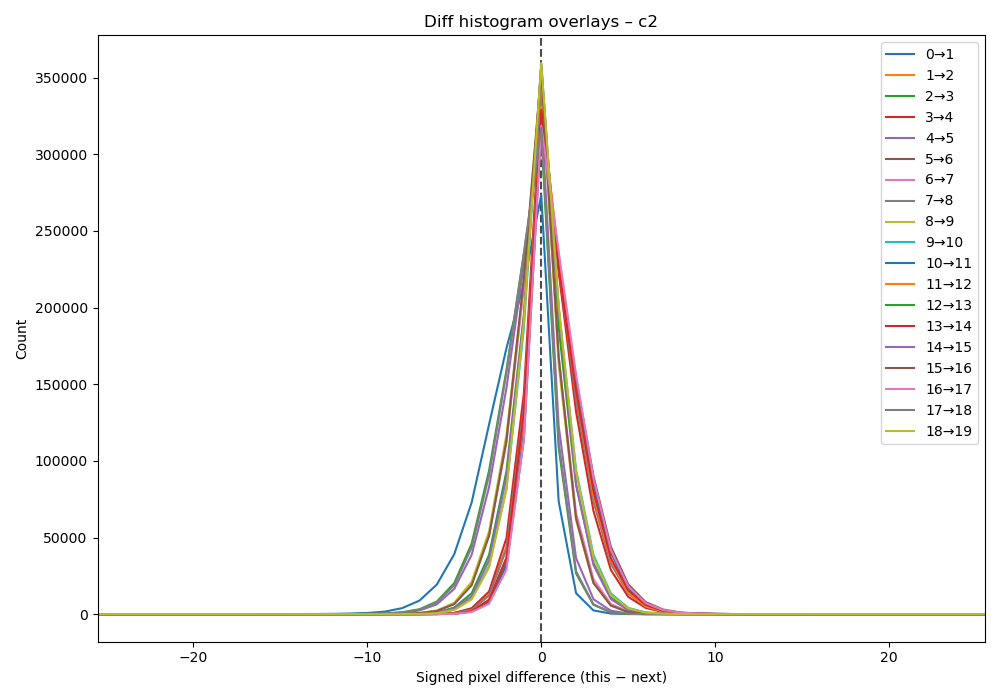

In [9]:
# Histogram bins centered at integers: -55..55
edges   = np.arange(-55.5, 55.5 + 1.0, 1.0)   # 112 edges -> 111 bins
centers = (edges[:-1] + edges[1:]) * 0.5      # -55..55

for cam in cam_order:
    # skip if camera missing or has fewer than 2 frames
    if cam not in frames:
        continue
    n_frames = len(frames[cam])
    if n_frames < 2:
        continue

    selected_idxs = range(n_frames - 1)  # pairs i -> i+1

    plt.figure(figsize=(10, 7))
    plt.axvline(0, color="k", linestyle="--", alpha=0.7)  # vertical line at 0

    for i in selected_idxs:
        a = np.asarray(frames[cam][i],   dtype=np.float64)
        b = np.asarray(frames[cam][i+1], dtype=np.float64)
        signed_diff = a - b
        base = signed_diff[..., 0] if signed_diff.ndim == 3 else signed_diff  # first channel if RGB
        h, _ = np.histogram(base.ravel(), bins=edges)
        plt.plot(centers, h, label=f"{i}→{i+1}")

    plt.xlim(-25.5, 25.5)
    plt.xlabel("Signed pixel difference (this − next)")
    plt.ylabel("Count")
    plt.title(f"Diff histogram overlays – {cam}")
    plt.legend()
    plt.tight_layout()
    plt.show()

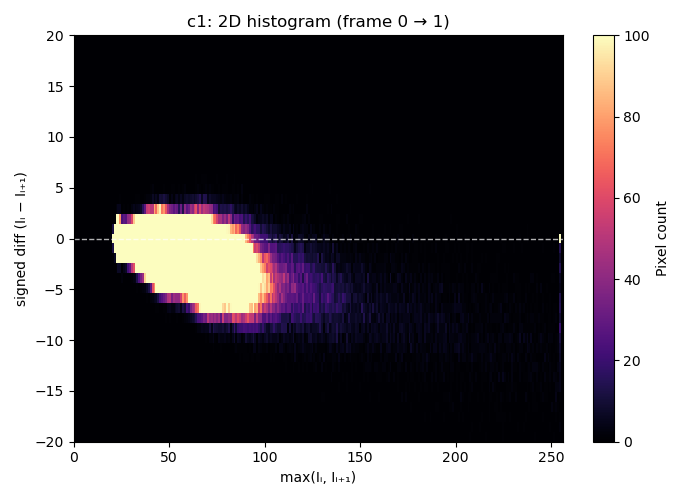

In [10]:

# --- choose camera and frame pair ---
cam = cam_order[0]   # e.g., 'c1'
i   = 0              # compare frame i vs i+1

# get the two frames
A = frames[cam][i]
B = frames[cam][i+1]

# grayscale if RGB
A = A[..., 0] if A.ndim == 3 else A
B = B[..., 0] if B.ndim == 3 else B

# convert to float for differences
A64 = A.astype(np.float64)
B64 = B.astype(np.float64)

# compute pixel-wise quantities
x = np.maximum(A64, B64).ravel()   # max intensity
y = (A64 - B64).ravel()            # signed diff

# make 2D histogram

xrange = [0,256]  # 256 for max intensity, ~±55 for diffs
yrange = [-20,20]

plt.figure(figsize=(7, 5))
hist, xedges, yedges, img = plt.hist2d(
    x, y,
    bins=[xrange[1]-xrange[0]+1, yrange[1]-yrange[0]+1],
    range=[xrange, yrange],
    cmap="magma",
    vmax= 100     # cap the intensity color scale
)

plt.colorbar(img, label="Pixel count")
plt.axhline(0, color='w', linestyle='--', linewidth=1, alpha=0.7)
plt.xlabel("max(Iᵢ, Iᵢ₊₁)")
plt.ylabel("signed diff (Iᵢ − Iᵢ₊₁)")
plt.title(f"{cam}: 2D histogram (frame {i} → {i+1})")
plt.tight_layout()
plt.show()

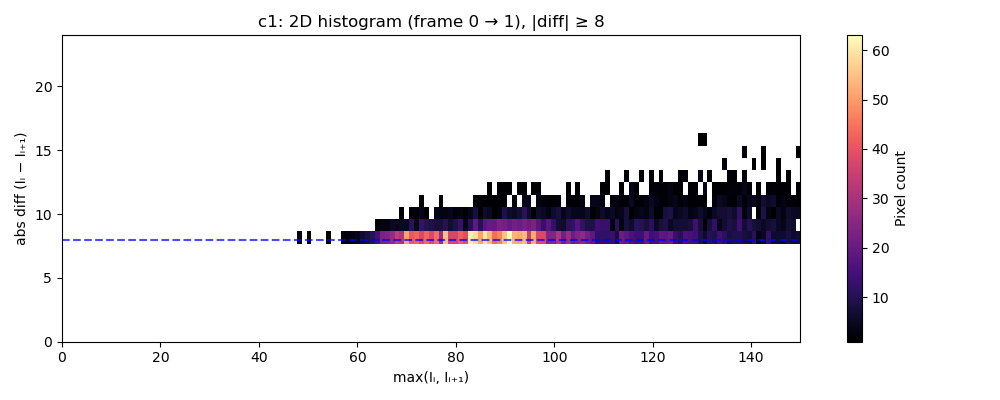

In [11]:
# --- choose camera and frame pair ---
cam = cam_order[0]   # e.g., 'c1'
i   = 0              # compare frame i vs i+1
th  = 8              # difference threshold

# get the two frames
A = frames[cam][i][..., 0]
B = frames[cam][i+1][..., 0]

# convert to float for differences
A64 = A.astype(np.float64)
B64 = B.astype(np.float64)

# compute pixel-wise quantities
x = np.maximum(A64, B64).ravel()   # max intensity
y = np.abs((A64 - B64).ravel())            # signed diff

# keep only pixels with |diff| >= threshold
mask = np.abs(y) >= th
x = x[mask]
y = y[mask]

# make 2D histogram
xrange = [0, 150]
yrange = [0, int(np.max(y))]

plt.figure(figsize=(10, 4))
plt.axhline(th, color='b', linestyle='--', linewidth=1.5, alpha=0.7)
hist, xedges, yedges, img = plt.hist2d(
    x, y,
    bins=[xrange[1]-xrange[0]+1, yrange[1]-yrange[0]+1],
    range=[xrange, yrange],
    cmap="magma",
    cmin = 1,
    #vmax=100    # cap the intensity color scale
)

plt.colorbar(img, label="Pixel count")
plt.xlabel("max(Iᵢ, Iᵢ₊₁)")
plt.ylabel("abs diff (Iᵢ − Iᵢ₊₁)")
plt.title(f"{cam}: 2D histogram (frame {i} → {i+1}), |diff| ≥ {th}")
plt.tight_layout()
plt.show()

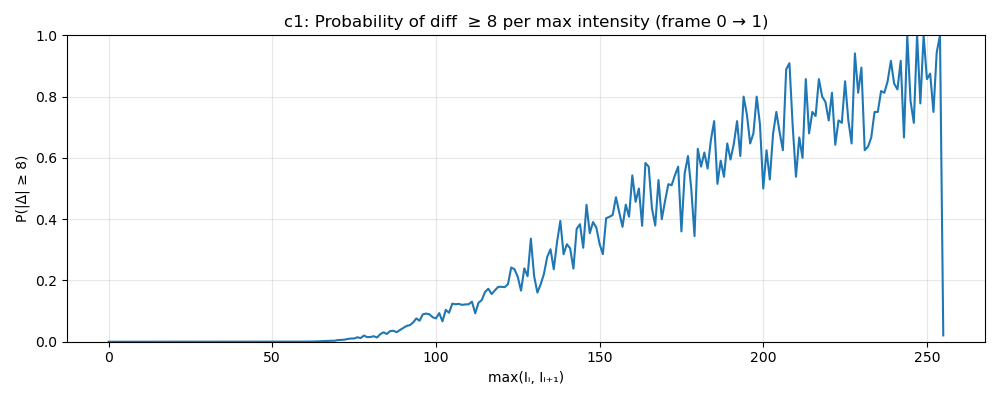

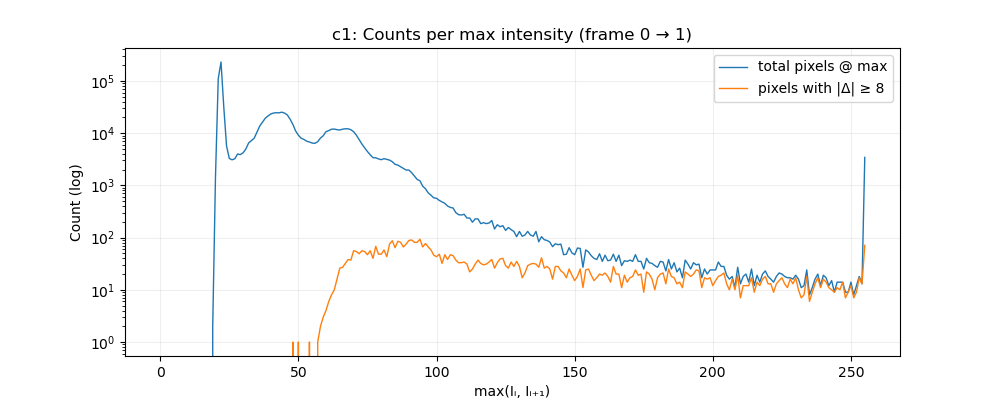

In [12]:
# promote for safe subtraction, compute quantities
A16 = A.astype(np.int16)
B16 = B.astype(np.int16)
max_int = np.maximum(A, B).astype(np.uint8)        # 0..255
diff_abs = np.abs(A16 - B16)                       # >= 0

# per-max-intensity counts using bincount
total_at_m = np.bincount(max_int.ravel(), minlength=256)

mask_large = diff_abs.ravel() >= th
large_at_m = np.bincount(max_int.ravel()[mask_large], minlength=256)

# probability per max intensity (safe division)
prob_at_m = np.divide(
    large_at_m, total_at_m,
    out=np.zeros_like(large_at_m, dtype=np.float64),
    where=total_at_m > 0
)

# --- Plot probability vs. max intensity
x = np.arange(256)

plt.figure(figsize=(10, 4))
plt.plot(x, prob_at_m, color="C0")
plt.ylim(0, 1)
plt.xlabel("max(Iᵢ, Iᵢ₊₁)")
plt.ylabel(f"P(|Δ| ≥ {th})")
plt.title(f"{cam}: Probability of diff  ≥ {th} per max intensity (frame {i} → {i+1})")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()





fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(x, total_at_m, label="total pixels @ max", linewidth=1)
ax.plot(x, large_at_m, label=f"pixels with |Δ| ≥ {th}", linewidth=1)
ax.set_yscale("log")  # counts can vary a lot
ax.set_xlabel("max(Iᵢ, Iᵢ₊₁)")
ax.set_ylabel("Count (log)")
ax.set_title(f"{cam}: Counts per max intensity (frame {i} → {i+1})")
ax.legend()
ax.grid(alpha=0.2)

plt.show()